This notebook kind of implementation of paper (https://arxiv.org/pdf/1704.07911.pdf) which explains how a deep neural network trained with end-to-end learning steers a car. <br>
<br>
This paper explains a method to find salient features that neural network considers while taking the decisions of steering.<br>

# Method to extract salient features

1) In each layer, activations of the feature maps are averaged. <br>
2) The top most averaged map is scaled up to the size of the map of the layer below. <br>
The upscaling is done using deconvolution. The kernel size and stride are chosen same as <br>
in the convolutional layer used to generate the map.<br>
3) The up-scaled averaged map from an upper level is then multiplied with the averaged map <br>
from the layer below. <br>
4) Repeat steps 2 and 3 till until the input is reached. <br>
5) The last mask which is of the size of the input image is <br>
normalized to the range from 0.0 to 1.0. <br>
<br>
<br>
Now this is visualisation map and shows which regions of the input image <br>
contribute most to the output of the network <br>

<img src="features.png">

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tqdm import tnrange
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam
import utils
import model
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [3]:
optimizer=Adam(1e-4, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model = model.get_model(optimizer)
model.load_weights('model_best_fit.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
outputs = [layer.output for layer in model.layers][1:6]
inputs = model.input
functor = K.function([inputs], outputs)

In [6]:
filenames = []

for filename in os.listdir('run1'):
    filenames.append(os.path.join('run1', filename))

In [7]:
images =[]
alpha = 0.002
beta = 1.0 - alpha

for i  in tnrange(len(filenames), desc='files'):
    if i > 499 :
        break
    img = utils.read_img(filenames[i])
    proc_img = utils.preprocess(img)
    img = img[40:-20, :, :]
    img = cv2.resize(img, (utils.IMG_WIDTH, utils.IMG_HT), cv2.INTER_AREA)
    layer_outs = functor([img.reshape(1, utils.IMG_HT, utils.IMG_WIDTH, utils.IMG_CH)])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = utils.get_salient_feature_mask(layer_outs)
    #stacked_mask = np.dstack((np.dstack((mask, mask)), mask))
    mask_img = cv2.addWeighted(img.astype('float32'), alpha, mask, beta, 0.0)
    norm_img = (mask_img - np.min(mask_img)) / (np.max(mask_img) - np.min(mask_img))
    images.append(norm_img)

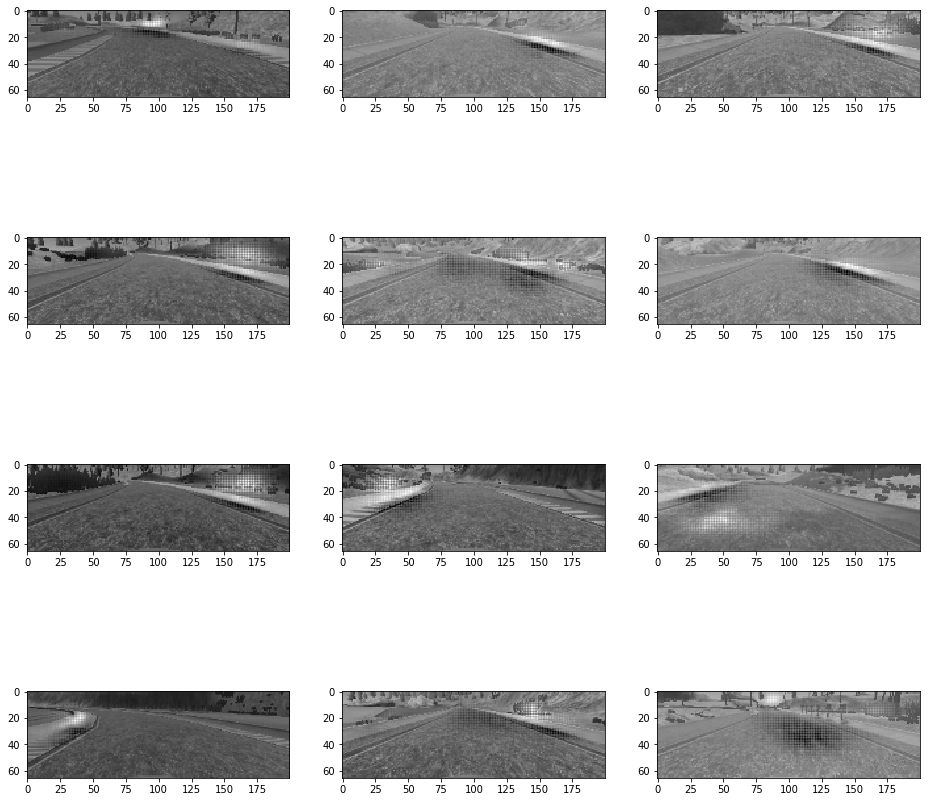

In [22]:
utils.display_multiple_images(images[:12], is_yuv=False, cmap='gray')